In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import layers
from keras.layers import StringLookup
import matplotlib.pyplot as plt

2025-11-17 14:19:23.618567: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-1m.zip", "movielens.zip")
ZipFile("movielens.zip", "r").extractall()

ratings_data = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "unix_timestamp"],
)

ratings_data["movie_id"] = ratings_data["movie_id"].apply(lambda x: f"movie_{x}")
ratings_data["user_id"] = ratings_data["user_id"].apply(lambda x: f"user_{x}")
ratings_data["rating"] = ratings_data["rating"].apply(lambda x: float(x))
del ratings_data["unix_timestamp"]

print(f"Number of users: {len(ratings_data.user_id.unique())}")
print(f"Number of movies: {len(ratings_data.movie_id.unique())}")
print(f"Number of ratings: {len(ratings_data.index)}")

/tmp/ipykernel_15796/2288473197.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings_data = pd.read_csv(


Number of users: 6040
Number of movies: 3706
Number of ratings: 1000209


In [3]:
random_selection = np.random.rand(len(ratings_data.index)) <= 0.85
train_data = ratings_data[random_selection]
eval_data = ratings_data[~random_selection]

train_data.to_csv("train_data.csv", index=False, sep="|", header=False)
eval_data.to_csv("eval_data.csv", index=False, sep="|", header=False)
print(f"Train data split: {len(train_data.index)}")
print(f"Eval data split: {len(eval_data.index)}")
print("Train and eval data files are saved.")

Train data split: 850017
Eval data split: 150192
Train and eval data files are saved.


In [4]:
csv_header = list(ratings_data.columns)
user_vocabulary = list(ratings_data.user_id.unique())
movie_vocabulary = list(ratings_data.movie_id.unique())
target_feature_name = "rating"
learning_rate = 0.001
batch_size = 128
num_epochs = 3
base_embedding_dim = 64

In [5]:
def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=True):
    return tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=csv_header,
        label_name=target_feature_name,
        num_epochs=1,
        header=False,
        field_delim="|",
        shuffle=shuffle,
    )


def run_experiment(model):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.MeanAbsoluteError(name="mae")],
    )
    # Read the training data.
    train_dataset = get_dataset_from_csv("train_data.csv", batch_size)
    # Read the test data.
    eval_dataset = get_dataset_from_csv("eval_data.csv", batch_size, shuffle=False)
    # Fit the model with the training data.
    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=eval_dataset,
    )
    return history

In [6]:
def embedding_encoder(vocabulary, embedding_dim, num_oov_indices=0, name=None):
    return keras.Sequential(
        [
            StringLookup(
                vocabulary=vocabulary, mask_token=None, num_oov_indices=num_oov_indices
            ),
            layers.Embedding(
                input_dim=len(vocabulary) + num_oov_indices, output_dim=embedding_dim
            ),
        ],
        name=f"{name}_embedding" if name else None,
    )

In [7]:
def create_baseline_model():
    # Receive the user as an input.
    user_input = layers.Input(name="user_id", shape=(), dtype=tf.string)
    # Get user embedding.
    user_embedding = embedding_encoder(
        vocabulary=user_vocabulary, embedding_dim=base_embedding_dim, name="user"
    )(user_input)

    # Receive the movie as an input.
    movie_input = layers.Input(name="movie_id", shape=(), dtype=tf.string)
    # Get embedding.
    movie_embedding = embedding_encoder(
        vocabulary=movie_vocabulary, embedding_dim=base_embedding_dim, name="movie"
    )(movie_input)

    # Compute dot product similarity between user and movie embeddings.
    logits = layers.Dot(axes=1, name="dot_similarity")(
        [user_embedding, movie_embedding]
    )
    # Convert to rating scale.
    prediction = keras.activations.sigmoid(logits) * 5
    # Create the model.
    model = keras.Model(
        inputs=[user_input, movie_input], outputs=prediction, name="baseline_model"
    )
    return model


baseline_model = create_baseline_model()
baseline_model.summary()

I0000 00:00:1763386131.705192   15796 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 597 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


Model: "baseline_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_id            │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 64)        │    386,560 │ user_id[0][0]     │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 64)        │    237,184 │ movie_id[0][0]    │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_similarity      │ (None, 1)         │          0 │ user_embedding[0… │
│ (Dot)               │                   │            │ movie_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigmoid (Sigmoid)   │ (None, 1)         │          0 │ dot_similarity[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1)         │          0 │ sigmoid[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 623,744 (2.38 MB)

 Trainable params: 623,744 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
   6623/Unknown 10s 1ms/step - loss: 1.3962 - mae: 0.9616

2025-11-17 14:29:12.450168: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/baseline_model_1/movie_embedding_1/string_lookup_1_1/StringFormat/_22]]
2025-11-17 14:29:12.450183: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17630968849317202088
2025-11-17 14:29:12.450187: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14709179773576442414
2025-11-17 14:29:12.450189: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-11-17 14:29:12.450199: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5682915064113859676
2025-11-17 14:29:12.450200: I tensorflow/core/framework/local_rendezvous.cc:426] Lo

6641/6641 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 1.1161 - mae: 0.8465 - val_loss: 0.8986 - val_mae: 0.7431
Epoch 2/3
  65/6641 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 1.1469 - mae: 0.8696

2025-11-17 14:29:13.751662: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/baseline_model_1/movie_embedding_1/string_lookup_1_1/None_Lookup/LookupTableFindV2/_8]]
2025-11-17 14:29:13.751684: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1543590722963865769
2025-11-17 14:29:13.751688: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1511210139776932721
2025-11-17 14:29:13.751692: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14911097349220801797
2025-11-17 14:29:13.751695: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3314797142235772873
2025-11-17 14:29:13.751698: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv 

6619/6641 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8236 - mae: 0.7165

2025-11-17 14:29:22.957852: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8828362583660663637
2025-11-17 14:29:22.957868: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18337925669939441205
2025-11-17 14:29:22.957873: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7834221911082983341
2025-11-17 14:29:22.957879: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17630968849317202088
2025-11-17 14:29:22.957883: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14709179773576442414
2025-11-17 14:29:22.957887: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8376054947277794416
2025-11-17 14:29:22.957891: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv 

6641/6641 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.7964 - mae: 0.7045 - val_loss: 0.7842 - val_mae: 0.6994
Epoch 3/3
  72/6641 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.7947 - mae: 0.7074

2025-11-17 14:29:24.239284: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/baseline_model_1/movie_embedding_1/string_lookup_1_1/None_Lookup/LookupTableFindV2/_8]]
2025-11-17 14:29:24.239300: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1543590722963865769
2025-11-17 14:29:24.239306: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1511210139776932721
2025-11-17 14:29:24.239311: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14911097349220801797
2025-11-17 14:29:24.239316: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3314797142235772873
2025-11-17 14:29:24.239321: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv 

6605/6641 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7306 - mae: 0.6746

2025-11-17 14:29:33.366586: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8828362583660663637
2025-11-17 14:29:33.366603: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18337925669939441205
2025-11-17 14:29:33.366608: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7834221911082983341
2025-11-17 14:29:33.366613: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17630968849317202088
2025-11-17 14:29:33.366617: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14709179773576442414
2025-11-17 14:29:33.366621: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8376054947277794416
2025-11-17 14:29:33.366624: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv 

6641/6641 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.7180 - mae: 0.6682 - val_loss: 0.7480 - val_mae: 0.6817


2025-11-17 14:29:34.581224: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1543590722963865769
2025-11-17 14:29:34.581238: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1511210139776932721
2025-11-17 14:29:34.581242: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14911097349220801797
2025-11-17 14:29:34.581246: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3314797142235772873
2025-11-17 14:29:34.581250: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11344297694640873576
2025-11-17 14:29:34.581253: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16823594314796415088
2025-11-17 14:29:34.581256: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv 

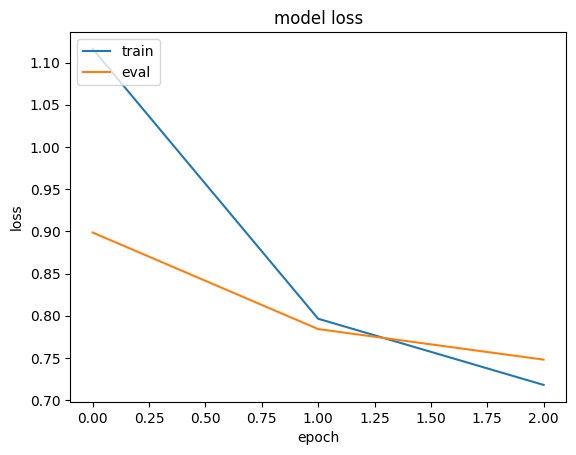

In [8]:
history = run_experiment(baseline_model)

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "eval"], loc="upper left")
plt.show()

In [9]:
class QREmbedding(keras.layers.Layer):
    def __init__(self, vocabulary, embedding_dim, num_buckets, name=None):
        super().__init__(name=name)
        self.num_buckets = num_buckets

        self.index_lookup = StringLookup(
            vocabulary=vocabulary, mask_token=None, num_oov_indices=0
        )
        self.q_embeddings = layers.Embedding(
            num_buckets,
            embedding_dim,
        )
        self.r_embeddings = layers.Embedding(
            num_buckets,
            embedding_dim,
        )

    def call(self, inputs):
        # Get the item index.
        embedding_index = self.index_lookup(inputs)
        # Get the quotient index.
        quotient_index = tf.math.floordiv(embedding_index, self.num_buckets)
        # Get the reminder index.
        remainder_index = tf.math.floormod(embedding_index, self.num_buckets)
        # Lookup the quotient_embedding using the quotient_index.
        quotient_embedding = self.q_embeddings(quotient_index)
        # Lookup the remainder_embedding using the remainder_index.
        remainder_embedding = self.r_embeddings(remainder_index)
        # Use multiplication as a combiner operation
        return quotient_embedding * remainder_embedding

In [10]:
class MDEmbedding(keras.layers.Layer):
    def __init__(
        self, blocks_vocabulary, blocks_embedding_dims, base_embedding_dim, name=None
    ):
        super().__init__(name=name)
        self.num_blocks = len(blocks_vocabulary)

        # Create vocab to block lookup.
        keys = []
        values = []
        for block_idx, block_vocab in enumerate(blocks_vocabulary):
            keys.extend(block_vocab)
            values.extend([block_idx] * len(block_vocab))
        self.vocab_to_block = tf.lookup.StaticHashTable(
            tf.lookup.KeyValueTensorInitializer(keys, values), default_value=-1
        )

        self.block_embedding_encoders = []
        self.block_embedding_projectors = []

        # Create block embedding encoders and projectors.
        for idx in range(self.num_blocks):
            vocabulary = blocks_vocabulary[idx]
            embedding_dim = blocks_embedding_dims[idx]
            block_embedding_encoder = embedding_encoder(
                vocabulary, embedding_dim, num_oov_indices=1
            )
            self.block_embedding_encoders.append(block_embedding_encoder)
            if embedding_dim == base_embedding_dim:
                self.block_embedding_projectors.append(layers.Lambda(lambda x: x))
            else:
                self.block_embedding_projectors.append(
                    layers.Dense(units=base_embedding_dim)
                )

    def call(self, inputs):
        # Get block index for each input item.
        block_indicies = self.vocab_to_block.lookup(inputs)
        # Initialize output embeddings to zeros.
        embeddings = tf.zeros(shape=(tf.shape(inputs)[0], base_embedding_dim))
        # Generate embeddings from blocks.
        for idx in range(self.num_blocks):
            # Lookup embeddings from the current block.
            block_embeddings = self.block_embedding_encoders[idx](inputs)
            # Project embeddings to base_embedding_dim.
            block_embeddings = self.block_embedding_projectors[idx](block_embeddings)
            # Create a mask to filter out embeddings of items that do not belong to the current block.
            mask = tf.expand_dims(tf.cast(block_indicies == idx, tf.dtypes.float32), 1)
            # Set the embeddings for the items not belonging to the current block to zeros.
            block_embeddings = block_embeddings * mask
            # Add the block embeddings to the final embeddings.
            embeddings += block_embeddings

        return embeddings

<Axes: >

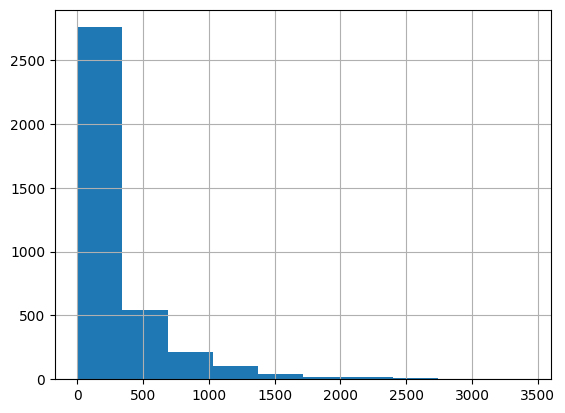

In [11]:
movie_frequencies = ratings_data["movie_id"].value_counts()
movie_frequencies.hist(bins=10)

In [12]:
sorted_movie_vocabulary = list(movie_frequencies.keys())

movie_blocks_vocabulary = [
    sorted_movie_vocabulary[:400],  # high popularity movies block
    sorted_movie_vocabulary[400:1700],  # normal popularity movies block
    sorted_movie_vocabulary[1700:],  # low popularity movies block
]

movie_blocks_embedding_dims = [64, 32, 16]

user_embedding_num_buckets = len(user_vocabulary) // 50


def create_memory_efficient_model():
    # Take the user as an input.
    user_input = layers.Input(name="user_id", shape=(), dtype="string")
    # Get user embedding.
    user_embedding = QREmbedding(
        vocabulary=user_vocabulary,
        embedding_dim=base_embedding_dim,
        num_buckets=user_embedding_num_buckets,
        name="user_embedding",
    )(user_input)

    # Take the movie as an input.
    movie_input = layers.Input(name="movie_id", shape=(), dtype="string")
    # Get embedding.
    movie_embedding = MDEmbedding(
        blocks_vocabulary=movie_blocks_vocabulary,
        blocks_embedding_dims=movie_blocks_embedding_dims,
        base_embedding_dim=base_embedding_dim,
        name="movie_embedding",
    )(movie_input)

    # Compute dot product similarity between user and movie embeddings.
    logits = layers.Dot(axes=1, name="dot_similarity")(
        [user_embedding, movie_embedding]
    )
    # Convert to rating scale.
    prediction = keras.activations.sigmoid(logits) * 5
    # Create the model.
    model = keras.Model(
        inputs=[user_input, movie_input], outputs=prediction, name="baseline_model"
    )
    return model


memory_efficient_model = create_memory_efficient_model()
memory_efficient_model.summary()

Model: "baseline_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_id            │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 64)        │     15,360 │ user_id[0][0]     │
│ (QREmbedding)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 64)        │    102,608 │ movie_id[0][0]    │
│ (MDEmbedding)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_similarity      │ (None, 1)         │          0 │ user_embedding[0… │
│ (Dot)               │                   │            │ movie_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigmoid_1 (Sigmoid) │ (None, 1)         │          0 │ dot_similarity[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 1)         │          0 │ sigmoid_1[0][0]   │
│ (Multiply)          │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 117,968 (460.81 KB)

 Trainable params: 117,968 (460.81 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
   6624/Unknown 15s 2ms/step - loss: 1.1863 - mae: 0.8753

2025-11-17 14:30:41.854879: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8803068707948679002
2025-11-17 14:30:41.854890: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 169752959986027249
2025-11-17 14:30:41.854899: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10877082210275746839
2025-11-17 14:30:41.854906: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17414981611128398856
2025-11-17 14:30:41.854910: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14275595458909027986
2025-11-17 14:30:41.854914: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7543188338231918368
/home/xy/Desktop/ml/TF/tf_2.20/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:164: Us

6641/6641 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.9937 - mae: 0.7967 - val_loss: 1.0793 - val_mae: 0.8095
Epoch 2/3
  46/6641 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 1.0914 - mae: 0.8358

2025-11-17 14:30:43.334678: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_8]]
2025-11-17 14:30:43.334694: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1753127582797846583
2025-11-17 14:30:43.334699: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14364253291368466891
2025-11-17 14:30:43.334701: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16732437931841241322
2025-11-17 14:30:43.334709: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17337990966144426734
2025-11-17 14:30:43.334715: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 93197754437204115
2025-11-17 14:30:43.334721: I tensorflow/core

6641/6641 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8827 - mae: 0.7456

2025-11-17 14:30:57.905844: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16570845540240300139
2025-11-17 14:30:57.905858: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 169752959986027249
2025-11-17 14:30:57.905861: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8803068707948679002
2025-11-17 14:30:57.905871: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17414981611128398856
2025-11-17 14:30:57.905875: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14275595458909027986
2025-11-17 14:30:57.905879: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7543188338231918368
2025-11-17 14:30:57.905881: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

6641/6641 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.8711 - mae: 0.7410 - val_loss: 0.9008 - val_mae: 0.7521
Epoch 3/3
  47/6641 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.9057 - mae: 0.7656

2025-11-17 14:30:59.201090: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16732437931841241322
2025-11-17 14:30:59.201102: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17337990966144426734
2025-11-17 14:30:59.201107: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4326791313191342944
2025-11-17 14:30:59.201111: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10963326212263047144
2025-11-17 14:30:59.201114: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1753127582797846583
2025-11-17 14:30:59.201123: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14364253291368466891
2025-11-17 14:30:59.201126: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

6636/6641 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8356 - mae: 0.7250

2025-11-17 14:31:14.166111: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8803068707948679002
2025-11-17 14:31:14.166124: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17414981611128398856
2025-11-17 14:31:14.166128: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14275595458909027986
2025-11-17 14:31:14.166130: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 169752959986027249
2025-11-17 14:31:14.166138: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10877082210275746839
2025-11-17 14:31:14.166145: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7543188338231918368


6641/6641 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.8295 - mae: 0.7220 - val_loss: 0.8701 - val_mae: 0.7391


2025-11-17 14:31:15.506073: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1753127582797846583
2025-11-17 14:31:15.506086: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 93197754437204115
2025-11-17 14:31:15.506089: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16732437931841241322
2025-11-17 14:31:15.506100: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14364253291368466891
2025-11-17 14:31:15.506103: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17337990966144426734
2025-11-17 14:31:15.506109: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10963326212263047144
2025-11-17 14:31:15.506111: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

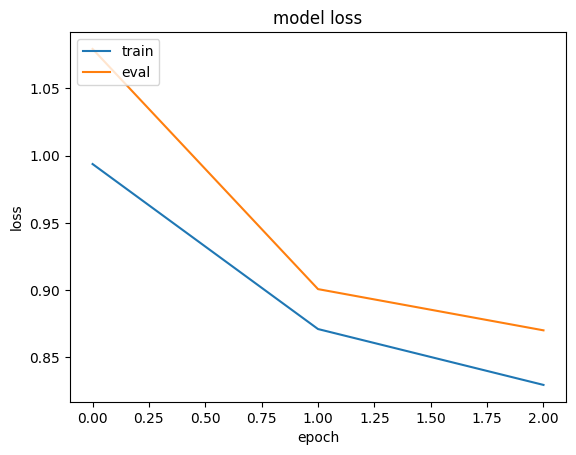

In [13]:
history = run_experiment(memory_efficient_model)

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "eval"], loc="upper left")
plt.show()